In [2]:
import os
import sep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval, LogStretch
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
plt.rcParams['figure.figsize'] = (12, 3)

In [3]:
DARK_DIR = '~/darks'

In [30]:
try:
    hour_dark_info = pd.read_csv('hour_dark_info.csv')
except FileNotFoundError:
    hour_darks = []
    for year in os.listdir(DARK_DIR):
        year_dir = os.path.join(DARK_DIR, year)
        for night in tqdm(os.listdir(year_dir)):
            night_dir = os.path.join(year_dir, night)
            for file in os.listdir(night_dir):
                path = os.path.join(night_dir, file)
                if '25' in path:
                    header = fits.getheader(path)
                    if header['EXPTIME'] == 3600:
                        hour_darks.append(path)
    hour_dark_info = []
    for path in hour_darks:
        year, night, file = path.split('/')[-3:]
        frame = file.split('.')[0].split('_')[2]
        channel = file.split('.')[0].split('_')[-1]
        hour_dark_info.append([year, night, frame, channel, path])
    hour_dark_info = pd.DataFrame(hour_dark_info, columns=['year', 'night', 'frame', 'channel', 'path'])
    hour_dark_info.to_csv('hour_dark_info.csv')

In [31]:
def plot_img(data_or_path):
    if type(data_or_path) is str:
        data = fits.getdata(data_or_path)
    else:
        data = data_or_path
    norm = ImageNormalize(data, ZScaleInterval())
    plt.imshow(data.T, norm=norm)
    plt.colorbar() 
    
def get_data(year, night, frame, channel, amp):
    info = {'year': year,
            'night': night,
            'frame': frame,
            'channel': channel.upper(),
            'amp': amp}
    subdir = '{year:02d}/{night:03d}/'.format(**info)
    fname = '{year:02d}_{night:03d}_{frame:03d}_001_25_{channel}.fits'.format(**info)
    path = os.path.join(DARK_DIR, subdir)
    path = os.path.join(path, fname)
    data, header = fits.getdata(path, header=True)
    if amp == 0:
        data = np.array(data[:, :1024]).byteswap().newbyteorder()
    else:
        data = np.array(data[:, 1024:]).byteswap().newbyteorder()
    return data, header

def get_objs(data):
    bg = sep.Background(data)
    bg.subfrom(data)
    objs = sep.extract(data, 1.5, err=bg.globalrms)
    objs = pd.DataFrame.from_records(objs)
    # Remove objects that are flagged
    objs = objs[objs.flag == 0]
    # Ellipticity cut
    objs = objs[1-objs.b/objs.a < 0.2]
    # Avoid objects on the edge of the detector
    objs = objs[(objs.xpeak > 10) & (objs.xpeak < 1014)]
    objs = objs[(objs.ypeak > 10) & (objs.ypeak < 4086)]
    return objs.reset_index()

def get_averages(data, objs):
    averages = []
    for section, subdf in objs.groupby(pd.cut(objs.ypeak, bins=np.linspace(0, 4096, 17))):
        windows = np.array([data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11]
                            for _, obj in subdf.iterrows()])
        p_clip_level = np.percentile(windows, 98, axis=0)
        windows[np.where(windows > p_clip_level)] = np.nan
        average = np.nanmean(windows, axis=0)
        averages.append(average)
    return np.array(averages)

def plot_obj(data, obj):
    window = data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11]
    norm = ImageNormalize(data, ZScaleInterval())
    plt.figure(figsize=(10, 10))
    plt.imshow(window, norm=norm)
    plt.colorbar()

In [75]:
hour_dark_info.sample(1)

,Unnamed: 0,year,night,frame,channel,path
3528,3528,7,252,41,B,/project/projectdirs/snfactry/SNIFS_from_deeps...


In [76]:
data, header = get_data(7, 252, 41, 'B', 0)
objs = get_objs(data)
print(header['EXPTIME'])

3600.0


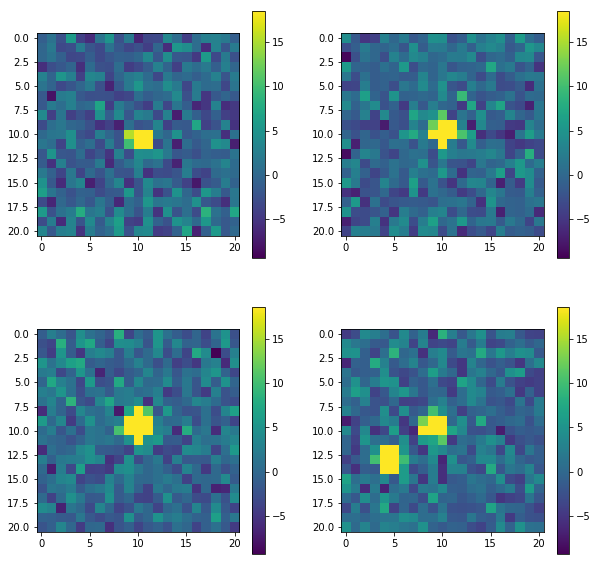

In [133]:
ex_objs = objs.sample(4)
ex_objs = ex_objs.reset_index()
plt.figure(figsize=(10, 10))
for i, obj in ex_objs.iterrows():
    plt.subplot(2, 2, i+1)
    window = data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11]
    norm = ImageNormalize(data, ZScaleInterval())
    plt.imshow(window, norm=norm)
    plt.colorbar()

(109, 21, 21) (108, 21, 21)


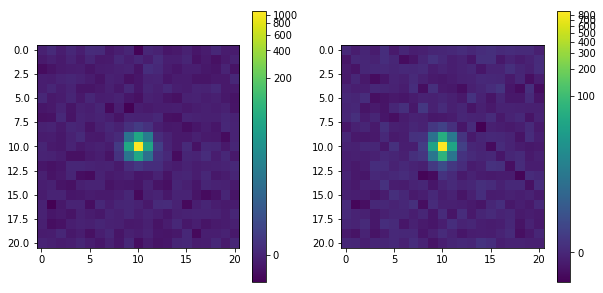

In [137]:
windows0, windows1 = [], []
for _, obj in objs.iterrows():
    if obj.ypeak < 256:
        windows0.append(data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11])
    if obj.ypeak > 3840:
        windows1.append(data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11])
windows0 = np.array(windows0)
windows1 = np.array(windows1)

print(windows0.shape, windows1.shape)

plt.figure(figsize=(10, 5))
for i, windows in enumerate([windows0, windows1]):
    p_clip_level = np.percentile(windows, 95, axis=0)
    windows[np.where(windows > p_clip_level)] = np.nan
    average = np.nanmean(windows, axis=0)
    norm = ImageNormalize(average, stretch=LogStretch())
    plt.subplot(1, 2, i+1)
    plt.imshow(average, norm=norm)
    plt.colorbar()

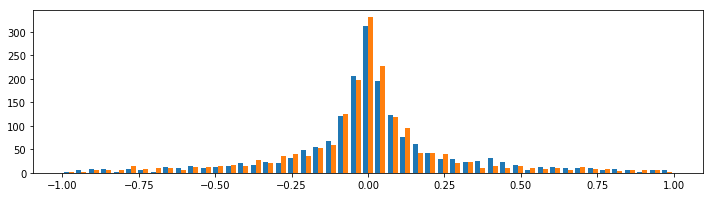

In [120]:
peaks, tails0, tails1 = [], [], []
for _, obj in objs.iterrows():
    x = int(obj.xpeak)
    y = int(obj.ypeak)
    peaks.append(data[y, x])
    tails0.append(data[y-10:y, x][::-1] - data[y+1:y+11, x])
    tails1.append(data[y, x-10:x][::-1] - data[y, x+1:x+11])
tails0 = np.array(tails0)
tails1 = np.array(tails1)
peaks = np.array(peaks)

n, bins, _ = plt.hist([np.sum(tails0, axis=1)/peaks, np.sum(tails1, axis=1)/peaks], bins=np.linspace(-1, 1));

In [8]:
hour_dark_info[(hour_dark_info.year==11) & (hour_dark_info.night==112) & (hour_dark_info.channel=='R')]

,Unnamed: 0,year,night,frame,channel,path
4317,4317,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4318,4318,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4319,4319,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4320,4320,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4321,4321,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4322,4322,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4323,4323,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4324,4324,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4325,4325,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...
4326,4326,11,112,97,R,/project/projectdirs/snfactry/SNIFS_from_deeps...


In [17]:
year = 10
channel = 'B'
amp = 0
year_channel_darks = hour_dark_info[(hour_dark_info.year==year) & (hour_dark_info.channel==channel)][:50]
aves = []
for _, frame in tqdm(year_channel_darks.iterrows(), total=len(year_channel_darks)):
    try:
        data, header = get_data(frame.year, frame.night, frame.frame, frame.channel, amp)
        objs = get_objs(data)
        aves.append(get_averages(data, objs))
    except:
        print(frame)
        continue
aves = np.array(aves)
print(aves.shape)

100%|██████████| 50/50 [00:28<00:00,  1.73it/s]

(50, 16, 21, 21)


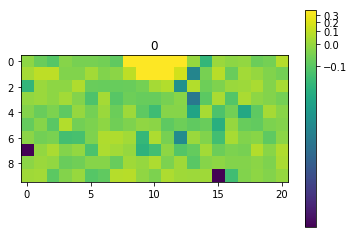

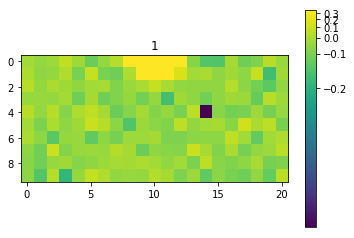

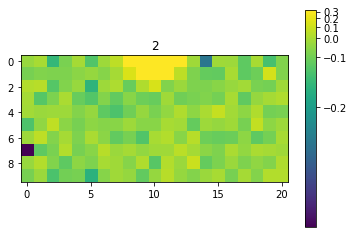

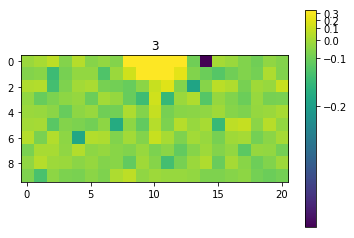

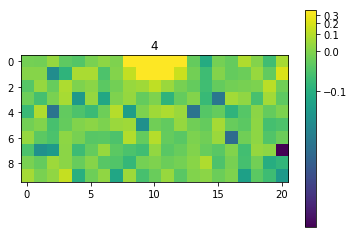

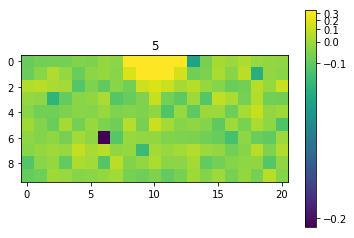

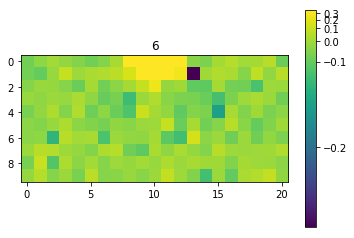

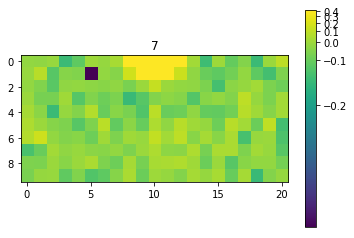

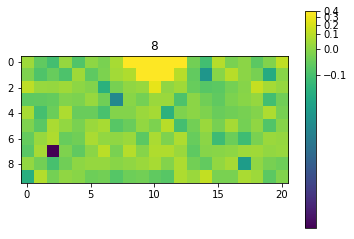

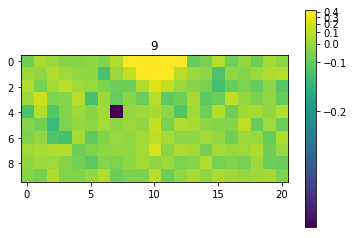

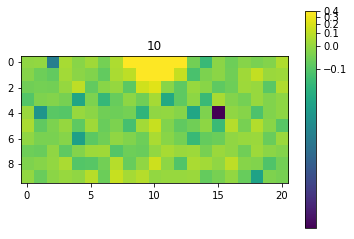

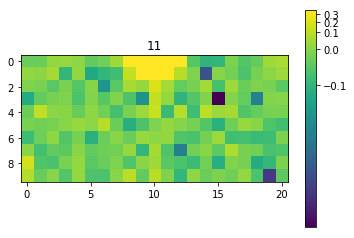

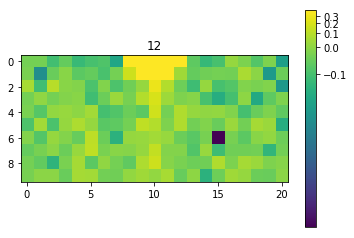

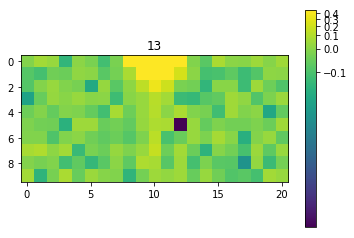

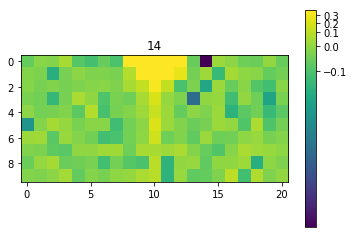

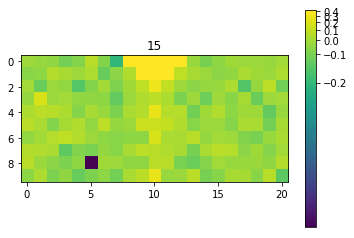

In [26]:
for i, ave in enumerate(np.median(aves, axis=0)):
    ave = ave[11:, :]# - np.flipud(ave[:10, :])
    plt.imshow(ave, norm=ImageNormalize(ave, ZScaleInterval(), stretch=LogStretch()))
    plt.title(i)
    plt.colorbar()
    plt.show()

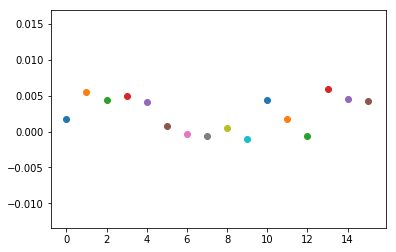

In [19]:
for i, ave in enumerate(np.mean(aves, axis=0)):
    plt.scatter(i, sum(ave[10, 11:] - ave[10, :10][::-1])/sum(ave[10, 7:13]))